In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt

from langevin.simulation import run_langevin_simulation
from langevin.analysis import compute_msd, estimate_diffusion_from_msd
from langevin.fitting import fit_model,linear

In [10]:
dt = 1e-2
n_particles = 100
t_max = 1000.
n_steps = int(t_max/dt)
m=1.0
gamma_l = 1.
gamma_g = 1e2
kB=1.
T =1.0
scheme = "explicit"

In [11]:
tau_ = np.logspace(-2,2,10)
msd_ = []
gamma_ = []
for i, tau in enumerate(tau_):
    start_ = time.time()
    
    # run simulations
    positions, velocities, gamma_values = run_langevin_simulation(
    T=T,tau=tau,n_steps=n_steps,n_particles=n_particles,dt=dt,gamma_l=gamma_l, gamma_g=gamma_g,m=m,kB=kB, scheme=scheme)

    # compute MSD
    t_msd, msd = compute_msd(positions, dt=dt)
    
    # append
    msd_.append(msd)
    gamma_.append(gamma_values)
    
    end_ = time.time()
    print(f"τ = {tau:.3f} | {end_ - start_:.2f} seconds")

τ = 0.010 | 4.44 seconds
τ = 0.028 | 4.53 seconds
τ = 0.077 | 4.32 seconds
τ = 0.215 | 4.27 seconds
τ = 0.599 | 4.24 seconds
τ = 1.668 | 4.22 seconds
τ = 4.642 | 4.21 seconds
τ = 12.915 | 4.18 seconds
τ = 35.938 | 4.20 seconds
τ = 100.000 | 4.31 seconds


In [12]:
# Analytical estimation
def D_over_D0_analytical(gamma_l,gamma_g,tau, kBT, m):
    nom = 0.5*(gamma_l-gamma_g)**2
    denom = 2*gamma_l*gamma_g + m*(gamma_l+gamma_g)/tau
    return 1+nom/denom


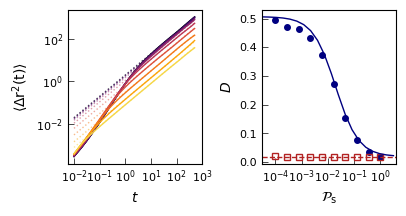

In [13]:
# calculate D_eff
    
# Plot MSD
plt.figure(figsize=(4., 2.1))

plt.subplot(1,2,1)
colors = plt.cm.inferno(np.linspace(0,0.9,len(tau_)))[::-1]
D_msd = []
for i in range(len(tau_)):
    msd_t = np.array(msd_[i])
    D_eff, popt, pcov = estimate_diffusion_from_msd(t_msd, msd_t)
    D_msd.append(D_eff)
    
for i in range(len(tau_))[::-1]:
    msd_t = np.array(msd_[i])
    D_eff, popt, pcov = estimate_diffusion_from_msd(t_msd, msd_t)
    if i==0 or i==4 or i == len(tau_)-1:#i % 3 == 0:  # show legend every 3 steps
        plt.plot(t_msd, msd_t, '-', c=colors[i], lw=1, alpha=1, markeredgecolor='none', label = r'$\mathcal{P}_{\mathrm{s}}$=10$^{%i}$'%np.log10(dt/tau_[i]))
                 #label=r'$\it{dt/\tau}$=10$^{%i}$'%np.log10(dt/tau_[i]))
    else:
        plt.plot(t_msd, msd_t, '-', c=colors[i], lw=1, alpha=1, markeredgecolor='none')
    plt.plot(t_msd, linear(t_msd, *popt*4), ':',lw=1, c=colors[i], alpha=0.5)
plt.xlabel(r"$\it{t}$", fontsize=10)
plt.ylabel(r'$\langle \Delta $r$^2$(t)$\rangle$', fontsize=10)
plt.xscale('log')
plt.yscale('log')
#plt.legend(frameon=False, fontsize=6)
plt.tick_params(axis='both', which='major', labelsize=8, direction='in', length=4, width=0.5)
plt.tick_params(axis='both', which='minor', labelsize=8, direction='in', length=2, width=0.5)
plt.xticks(np.logspace(-2,3,6))
#plt.yticks(np.logspace(-5,4,10))
#plt.text(-.35, 1.5,'a',weight='bold')


tau_an = np.logspace(-2.5, 2.5, 20)
D_an = D_over_D0_analytical(gamma_l,gamma_g,tau_an, kB*T, m)

gamma_avg = np.average(np.array(gamma_)[:,:,1:], axis=(1,2))
D_SE = np.array(kB*T/gamma_avg)
#plt.text(2e-5, 5e3,'(a)')

plt.subplot(1,2,2)
plt.plot(dt/tau_, np.array(D_msd), 'o', ms=4, c='navy', label=r'$\langle \Delta$r$^2$$\rangle$/(4t)')
plt.plot(dt/tau_, D_SE, 's', ms=4, c='firebrick', label=r'k$_B$T/$\langle γ \rangle$',markerfacecolor="None")
plt.plot(dt/tau_an,D_an*np.mean(D_SE), lw=1, c='navy', label='theory')
plt.axhline(y=np.mean(D_SE), lw=1, ls='--',c='firebrick')
plt.xscale("log")
plt.xlabel(r"$\mathcal{P}_{\mathrm{s}}$", fontsize=10)
plt.ylabel(r"$\it{D}$", fontsize=10)
#plt.legend(frameon=False, fontsize=6)
plt.tick_params(axis='both', which='major', labelsize=8, direction='in', length=4, width=0.5)
plt.tick_params(axis='both', which='minor', labelsize=8, direction='in', length=2, width=0.5)
plt.xticks(np.logspace(-4,0,5))
#plt.ylim(-0.05, .55)
plt.xlim(3e-5,4)
#plt.text(6e-7, 0.52,'(b)')

plt.tight_layout(pad=0.5)

#plt.savefig('figs/Fig2.pdf', dpi=300)

plt.show()

Text(0.5, 0, '$P_s$')

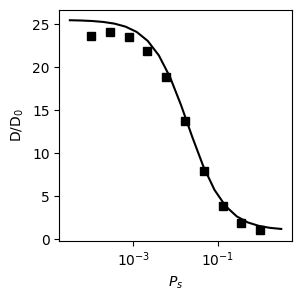

In [14]:
plt.figure(figsize=[3,3])
plt.plot(dt/tau_, D_msd/D_SE,'s',c='black')
plt.plot(dt/tau_an,D_an,c='black')
plt.xscale('log')
plt.ylabel(r'D/D$_0$')
plt.xlabel(r'$P_s$')
#plt.yscale('log')
